In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, save_model, load_model, split_dct_img, majority_vote, pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os

In [2]:
MODEL_TYPE = "rf"
PATH_MODELS = f"../models/train_on_blocks/{MODEL_TYPE}/"
DATASETS = [1, 4, 7]  # D3 with Q10 Q50 Q90
MODEL_NAME = ''.join([str(MODEL_TYPE)] + ['_c' + str(curr) for curr in DATASETS])

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

MODELS = {
    "rf": RandomForestClassifier(max_depth=2, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=False))
}

In [4]:
def get_trained_model(model, PATH_MODELS, MODEL_NAME, X_train_block=None, y_train_block=None):
    if not (os.path.exists(os.path.join(PATH_MODELS, MODEL_NAME + '.pickle'))):
        print(f"Training {MODEL_NAME}, please wait...")
        model.fit(X_train_block, y_train_block)
        print(f"Saving {MODEL_NAME} at {os.path.join(PATH_MODELS, MODEL_NAME)}.pickle")
        save_model(model, PATH_MODELS, MODEL_NAME)
    else:
        print(f"Loading {MODEL_NAME}, please wait...")
        model = load_model(PATH_MODELS, MODEL_NAME)
    return model

## Load datasets 1 4 7

In [5]:
X = []
y = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y += [current_dataset] * len(X_current)
    X += X_current

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_block, y_train_block = split_dct_img(X_train, y_train)
X_test_block, y_test_block = split_dct_img(X_test, y_test)

## Train (or load) model and predict on X_test

In [6]:
model = get_trained_model(MODELS[MODEL_TYPE], PATH_MODELS, MODEL_NAME, X_train_block, y_train_block)
y_pred_block = model.predict(X_test_block)
print(classification_report(y_test_block, y_pred_block))

Loading rf_c1_c4_c7, please wait...
              precision    recall  f1-score   support

           1       0.93      0.62      0.74    175104
           4       0.85      1.00      0.92    119808
           7       0.67      0.84      0.75    141312

    accuracy                           0.80    436224
   macro avg       0.81      0.82      0.80    436224
weighted avg       0.82      0.80      0.79    436224



## Majority vote to predict y for each image

In [7]:
y_pred = majority_vote(model, X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.91      0.95        57
           4       1.00      1.00      1.00        39
           7       0.90      1.00      0.95        46

    accuracy                           0.96       142
   macro avg       0.97      0.97      0.97       142
weighted avg       0.97      0.96      0.96       142



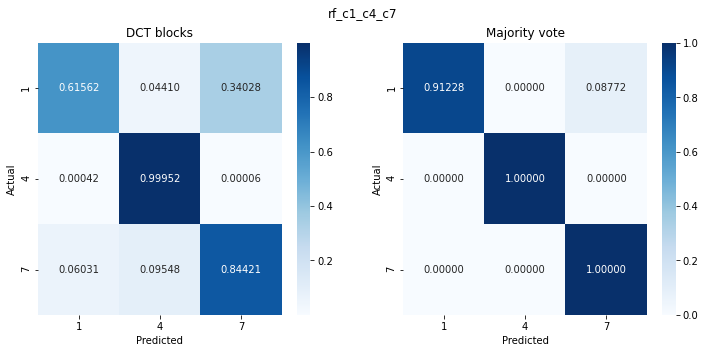

In [8]:
plt.figure(figsize=(12, 5))
plt.suptitle(MODEL_NAME)
plt.subplot(121)
show_confusion_matrix(y_test_block, y_pred_block, DATASETS, "DCT blocks", False)
plt.subplot(122)
show_confusion_matrix(y_test, y_pred, DATASETS, "Majority vote", False)
plt.show()

## Same DCT function but different quantization matrices
### d3 with Q10 Q50 and Q90

Loading rf_c3_c6_c9, please wait...
              precision    recall  f1-score   support

           3       0.96      1.00      0.98    175104
           6       0.81      0.97      0.89    119808
           9       0.97      0.76      0.85    141312

    accuracy                           0.91    436224
   macro avg       0.92      0.91      0.91    436224
weighted avg       0.92      0.91      0.91    436224

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        57
           6       1.00      1.00      1.00        39
           9       1.00      1.00      1.00        46

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



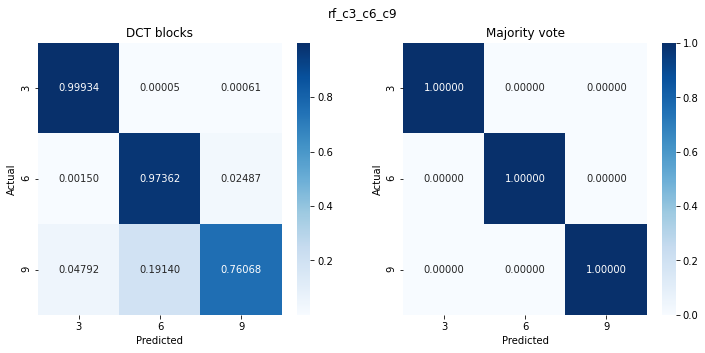

In [9]:
pipeline("rf", [3, 6, 9])

Loading adaboost_c2_c5_c8, please wait...
              precision    recall  f1-score   support

           2       1.00      0.45      0.62    175104
           5       0.54      0.96      0.70    119808
           8       0.97      1.00      0.98    141312

    accuracy                           0.77    436224
   macro avg       0.84      0.80      0.77    436224
weighted avg       0.86      0.77      0.76    436224

              precision    recall  f1-score   support

           2       1.00      0.30      0.46        57
           5       0.49      1.00      0.66        39
           8       1.00      1.00      1.00        46

    accuracy                           0.72       142
   macro avg       0.83      0.77      0.71       142
weighted avg       0.86      0.72      0.69       142



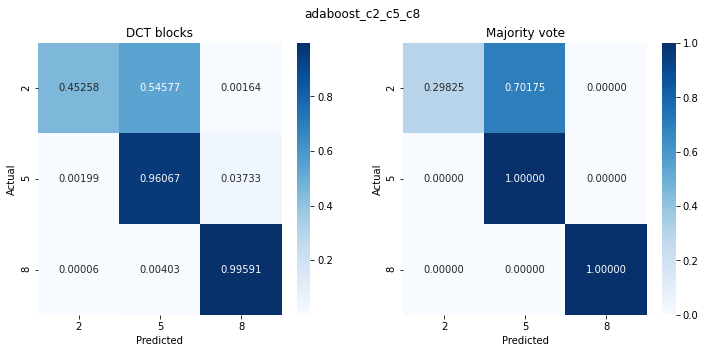

In [10]:
pipeline("adaboost", [2, 5, 8])

## Same quantization matrix but different DCT functions
### Q50
### d1 d2 d3 random forest

Loading rf_c1_c5_c9, please wait...
              precision    recall  f1-score   support

           1       0.79      0.88      0.83    175104
           5       0.63      0.33      0.43    119808
           9       0.63      0.80      0.70    141312

    accuracy                           0.70    436224
   macro avg       0.68      0.67      0.65    436224
weighted avg       0.69      0.70      0.68    436224

              precision    recall  f1-score   support

           1       0.95      1.00      0.97        57
           5       1.00      0.23      0.38        39
           9       0.63      1.00      0.77        46

    accuracy                           0.79       142
   macro avg       0.86      0.74      0.71       142
weighted avg       0.86      0.79      0.74       142



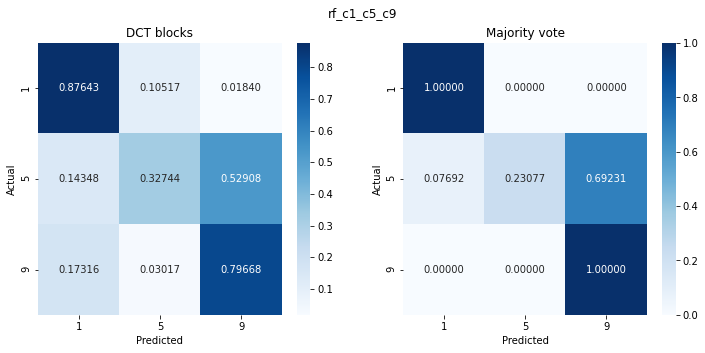

In [11]:
pipeline("rf", [1, 5, 9])  #Q50

### d2 d3 adaboost

Loading adaboost_c5_c9, please wait...
              precision    recall  f1-score   support

           5       0.74      0.87      0.80    147456
           9       0.84      0.69      0.76    144384

    accuracy                           0.78    291840
   macro avg       0.79      0.78      0.78    291840
weighted avg       0.79      0.78      0.78    291840

              precision    recall  f1-score   support

           5       0.91      1.00      0.95        48
           9       1.00      0.89      0.94        47

    accuracy                           0.95        95
   macro avg       0.95      0.95      0.95        95
weighted avg       0.95      0.95      0.95        95



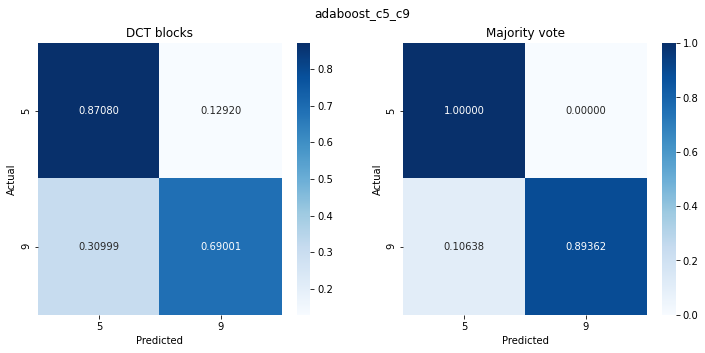

In [12]:
pipeline("adaboost", [5, 9])  #Q50

### d1 d2 d3 adaboost

Loading adaboost_c1_c5_c9, please wait...
              precision    recall  f1-score   support

           1       0.81      0.95      0.88    175104
           5       0.82      0.52      0.64    119808
           9       0.74      0.82      0.78    141312

    accuracy                           0.79    436224
   macro avg       0.79      0.76      0.76    436224
weighted avg       0.79      0.79      0.78    436224

              precision    recall  f1-score   support

           1       0.97      1.00      0.98        57
           5       1.00      0.72      0.84        39
           9       0.84      1.00      0.91        46

    accuracy                           0.92       142
   macro avg       0.93      0.91      0.91       142
weighted avg       0.93      0.92      0.92       142



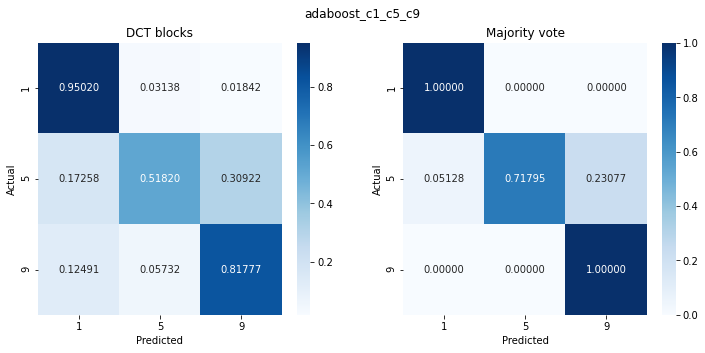

In [13]:
pipeline("adaboost", [1, 5, 9])  #Q50

### Q90
### d1 d2 d3 random forest

Loading rf_c2_c6_c7, please wait...
              precision    recall  f1-score   support

           2       0.99      0.22      0.36    175104
           6       0.50      0.85      0.63    119808
           7       0.71      0.98      0.83    141312

    accuracy                           0.64    436224
   macro avg       0.74      0.68      0.61    436224
weighted avg       0.77      0.64      0.59    436224

              precision    recall  f1-score   support

           2       1.00      0.05      0.10        57
           6       0.44      1.00      0.61        39
           7       0.92      1.00      0.96        46

    accuracy                           0.62       142
   macro avg       0.79      0.68      0.56       142
weighted avg       0.82      0.62      0.52       142



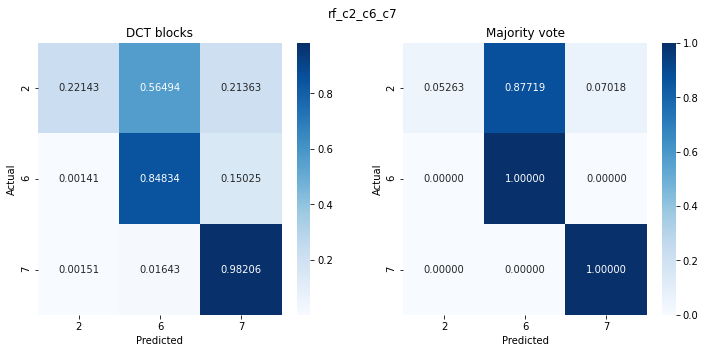

In [14]:
pipeline("rf", [2, 6, 7])  #Q90

### d2 d3 adaboost

Loading adaboost_c2_c6, please wait...
              precision    recall  f1-score   support

           2       0.92      0.83      0.87    147456
           6       0.84      0.93      0.88    144384

    accuracy                           0.88    291840
   macro avg       0.88      0.88      0.88    291840
weighted avg       0.88      0.88      0.88    291840

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        48
           6       1.00      1.00      1.00        47

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



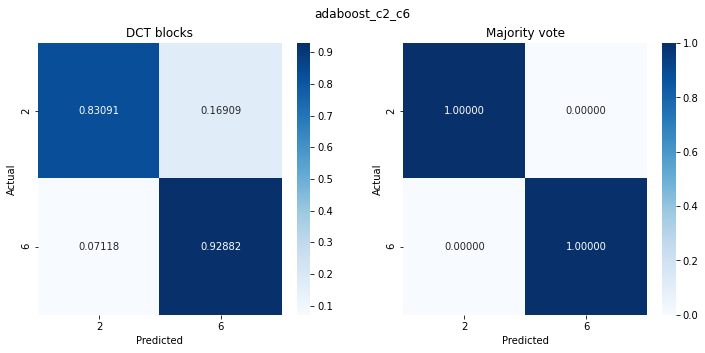

In [15]:
pipeline("adaboost", [2, 6])  #Q90

### Q10
### d2 d3 random forest

Loading rf_c3_c8, please wait...
              precision    recall  f1-score   support

           3       0.59      0.97      0.73    147456
           8       0.89      0.30      0.45    144384

    accuracy                           0.64    291840
   macro avg       0.74      0.63      0.59    291840
weighted avg       0.74      0.64      0.59    291840

              precision    recall  f1-score   support

           3       0.55      1.00      0.71        48
           8       1.00      0.15      0.26        47

    accuracy                           0.58        95
   macro avg       0.77      0.57      0.48        95
weighted avg       0.77      0.58      0.48        95



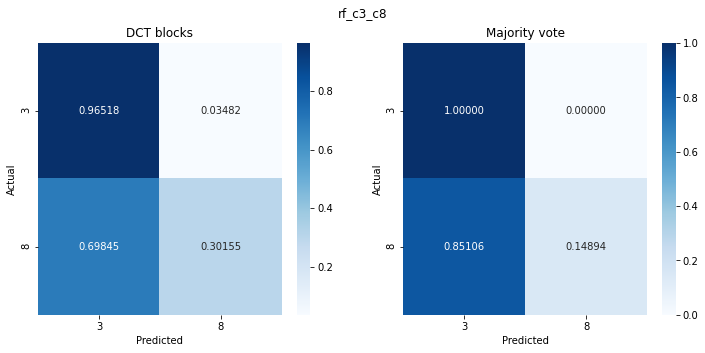

In [16]:
pipeline("rf", [3, 8])  #Q10

### d2 d3 adaboost

Loading adaboost_c3_c8, please wait...
              precision    recall  f1-score   support

           3       0.78      0.65      0.71    147456
           8       0.69      0.82      0.75    144384

    accuracy                           0.73    291840
   macro avg       0.74      0.73      0.73    291840
weighted avg       0.74      0.73      0.73    291840

              precision    recall  f1-score   support

           3       1.00      0.83      0.91        48
           8       0.85      1.00      0.92        47

    accuracy                           0.92        95
   macro avg       0.93      0.92      0.92        95
weighted avg       0.93      0.92      0.92        95



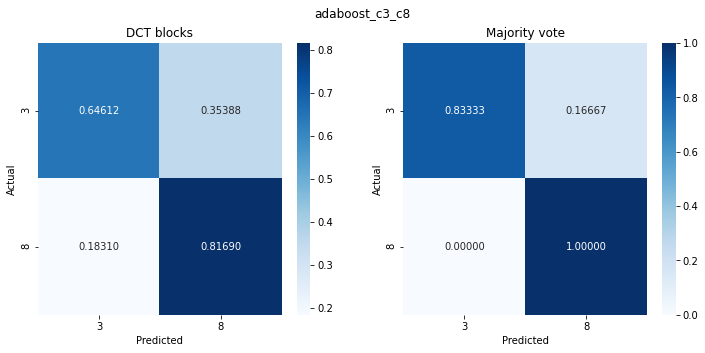

In [18]:
pipeline("adaboost", [3, 8])  #Q10

### d1 d2 d3 adaboost

Loading adaboost_c3_c4_c8, please wait...
              precision    recall  f1-score   support

           3       0.90      0.39      0.54    175104
           4       0.69      0.96      0.80    119808
           8       0.55      0.75      0.63    141312

    accuracy                           0.66    436224
   macro avg       0.71      0.70      0.66    436224
weighted avg       0.73      0.66      0.64    436224

              precision    recall  f1-score   support

           3       1.00      0.28      0.44        57
           4       0.95      1.00      0.97        39
           8       0.54      1.00      0.70        46

    accuracy                           0.71       142
   macro avg       0.83      0.76      0.71       142
weighted avg       0.84      0.71      0.67       142



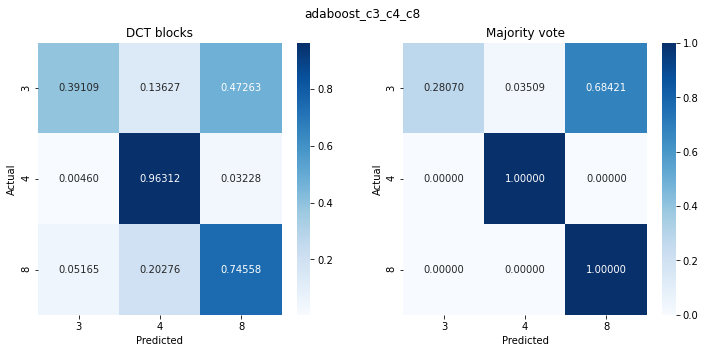

In [17]:
pipeline("adaboost", [3, 4, 8])  #Q10